# Getting started:

Create a virtual environment to manage dependencies and avoid conflicts with other projects. You can do this using `venv` or `conda`.

Then, ensure that the necessary basic libraries are installed. You can install them using the following command:

```bash
pip install -r requirements.txt
```

The script also quires the following:
- Pytorch: https://pytorch.org/get-started/locally/
- Segment Anything Model (SAM):
    ```bash
    pip install git+https://github.com/facebookresearch/segment-anything.git
    ```

# Model Pipeline

In [104]:
import matplotlib.pyplot as plt
from PIL import Image

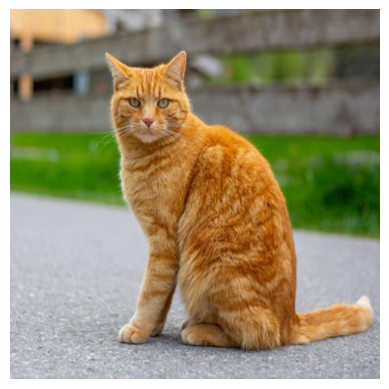

In [105]:
image = Image.open("cat4.avif").resize((512, 512)).convert("RGB")

plt.imshow(image)
plt.axis('off')
plt.show()

In [106]:
import numpy as np
import torch
import torch.nn.functional as F
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import os, urllib.request

Image size: 512x512
SAM loaded on cpu
Generating masks...


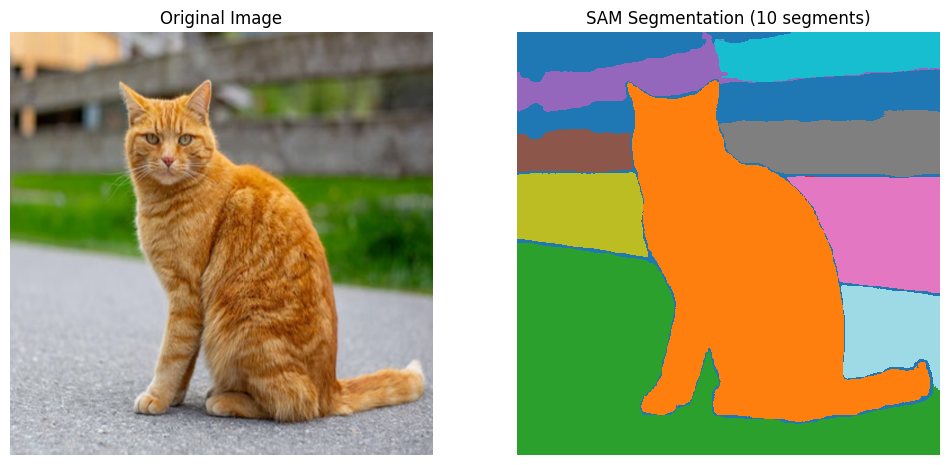

In [107]:
TOP_N = 10

height, width = image.size[1], image.size[0]
print(f"Image size: {width}x{height}")

checkpoint_path = "sam_vit_b_01ec64.pth"
if not os.path.exists(checkpoint_path):
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    urllib.request.urlretrieve(url, checkpoint_path)


sam = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)
print(f"SAM loaded on {device}")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.85,
    min_mask_region_area=500,
)

print("Generating masks...")
masks = mask_generator.generate(np.array(image))
masks_sorted = sorted(masks, key=lambda x: x['area'], reverse=True)

predicted_panoptic_map = np.zeros((height, width), dtype=np.int32)
for idx, mask_data in enumerate(masks_sorted[:TOP_N]):
    predicted_panoptic_map[mask_data['segmentation']] = idx + 1

predicted_panoptic_map = torch.from_numpy(predicted_panoptic_map)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_panoptic_map, cmap=f'tab20', interpolation='nearest')
plt.title(f'SAM Segmentation ({len(masks_sorted[:TOP_N])} segments)')
plt.axis('off')
plt.show()

In [108]:
import torchvision.transforms as tf
import torch

from transformers import AutoImageProcessor, AutoModelForImageClassification

In [109]:
transform = tf.Compose([tf.PILToTensor()])
img_tensor = transform(image)

def get_mask_box(tensor: torch.Tensor) -> tuple:
    """
    Get part of the bounding box of the non-zero elements in a tensor.
    Args:
        tensor (torch.Tensor): Input tensor.
    Returns:
        tuple: (first_n, last_n) where first_n is the index of the first non-zero element,
               and last_n is the index of the last non-zero element.
    """

    non_zero_indices = torch.nonzero(tensor, as_tuple=True)[0]
    if non_zero_indices.shape[0] == 0:
        return None, None
    first_n = non_zero_indices[:1].item()
    last_n = non_zero_indices[-1:].item()

    return first_n, last_n

segments = []
for label in predicted_panoptic_map.unique():
    
    y_start, y_end = get_mask_box(predicted_panoptic_map==label)
    x_start, x_end = get_mask_box((predicted_panoptic_map==label).T)

    cropped_tensor = img_tensor[:, y_start:y_end+1, x_start:x_end+1]
    cropped_mask = predicted_panoptic_map[y_start:y_end+1, x_start:x_end+1] == label

    segment = cropped_tensor * cropped_mask.unsqueeze(0)
    segment[:, ~cropped_mask] = 188

    segments.append(segment)

In [110]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
class_model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

In [111]:
predicted_classes = []

for segment in segments:
    inputs = image_processor(images=segment, return_tensors="pt")
    outputs = class_model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = class_model.config.id2label[predicted_class_idx]
    predicted_classes.append(predicted_class)

In [112]:
from transformers import pipeline

In [113]:
label_classifier = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli")
candidate_labels = [
    "car",
    "cat",
    "tree",
    "dog",
    "building",
    "person",
    "sky",
    "ground",
    "hardware",
]

Device set to use mps:0


In [114]:
labels = []

for predicted_class in predicted_classes:
    result = label_classifier(predicted_class, candidate_labels=candidate_labels)
    label = result['labels'][0] 
    labels.append(label)

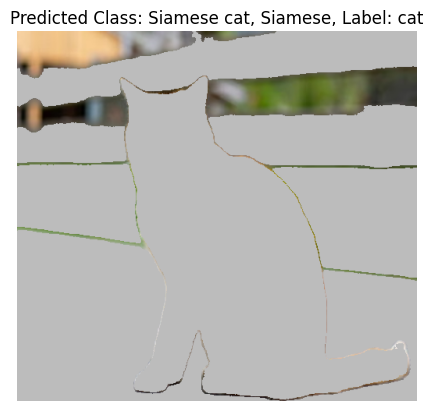

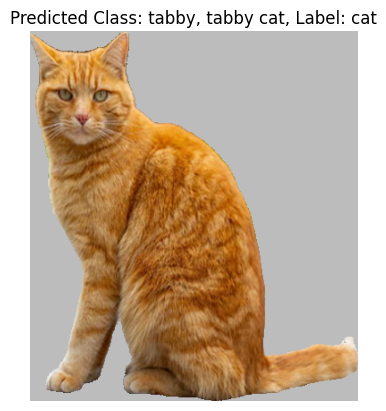

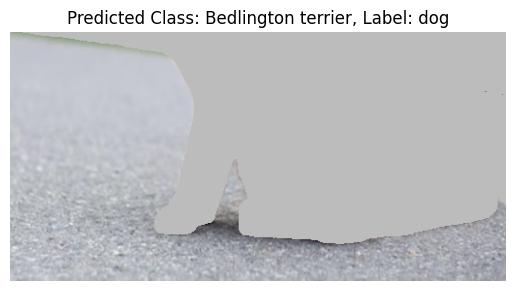

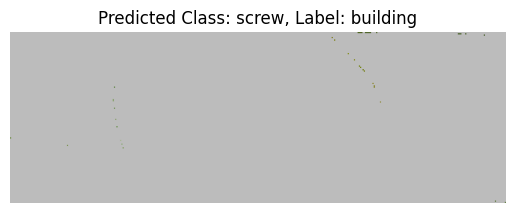

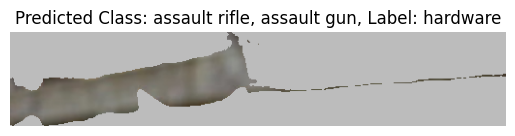

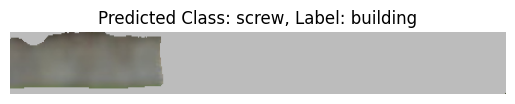

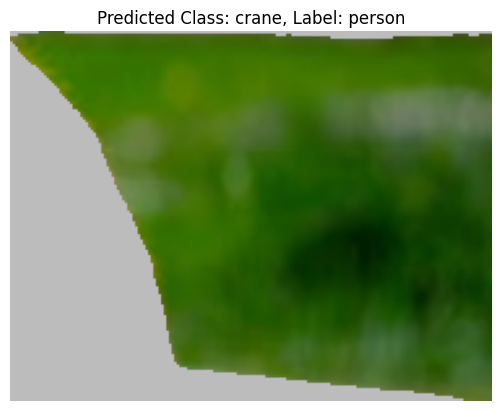

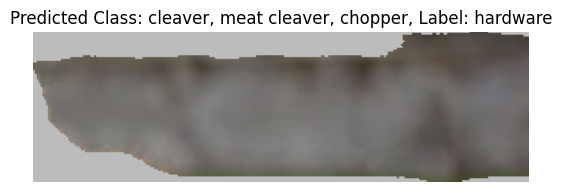

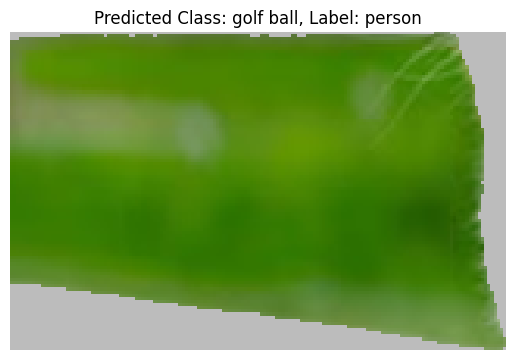

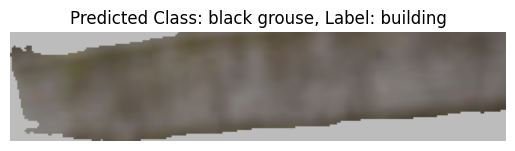

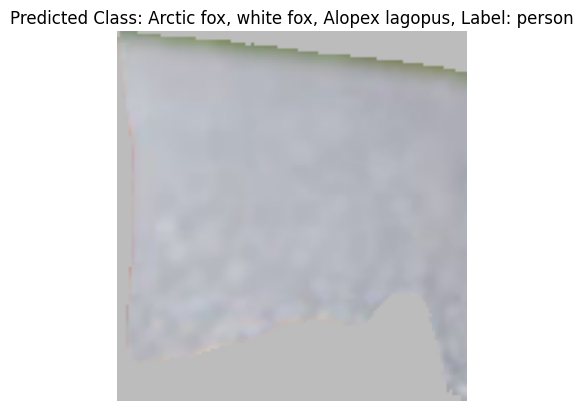

In [115]:
for segment, label, predicted_class in zip(segments, labels, predicted_classes):
    plt.imshow(segment.permute(1, 2, 0).numpy().astype(int))
    plt.title(f"Predicted Class: {predicted_class}, Label: {label}")
    plt.axis('off')
    plt.show()